In [26]:
!git clone https://github.com/abecode/teaching_reviews.git


fatal: destination path 'teaching_reviews' already exists and is not an empty directory.


In [27]:
!cp /content/teaching_reviews/data_prodigy/prodigy.sentence-level.20240701.db /content/

In [28]:
!ls /content/

prodigy.sentence-level.20240701.db  sample_data  teaching_reviews


In [29]:
import sqlite3

db_path = '/content/prodigy.sentence-level.20240701.db'


In [30]:
conn = sqlite3.connect(db_path)

In [31]:
sakthi_annotations = conn.execute("""select dataset.id, dataset.name, dataset.created, dataset.meta, dataset.session,
                                        example.id, example.input_hash, example.task_hash, example.content
                                 from dataset, example, link
                                 where dataset.id = link.dataset_id
                                   and link.example_id = example.id
                                   and dataset.name = 'teaching_reviews_sentences-sakthi';""").fetchall()

In [32]:
len(sakthi_annotations)

725

In [33]:
jenny_annotations = conn.execute("""select dataset.id, dataset.name, dataset.created, dataset.meta, dataset.session,
                                        example.id, example.input_hash, example.task_hash, example.content
                                 from dataset, example, link
                                 where dataset.id = link.dataset_id
                                   and link.example_id = example.id
                                   and dataset.name = 'teaching_reviews_sentences-jenny';""").fetchall()


In [34]:
len(jenny_annotations)

725

In [35]:
input_hashes = [];
task_hashes = [];
for annotation in sakthi_annotations:
  input_hashes.append(annotation[5])
  task_hashes.append(annotation[6])
for annotation in jenny_annotations:
  input_hashes.append(annotation[5])
  task_hashes.append(annotation[6])

In [36]:
print(len(input_hashes))
print(len(task_hashes))
print(len(set(input_hashes)))
print(len(set(task_hashes)))

1450
1450
1450
725


In [37]:
import pandas as pd
import json

In [38]:
sakthi_anno_df = pd.DataFrame({"annotator": ["sakthi" for x in sakthi_annotations],
                           "annotation":  [json.loads(x[8])['accept'] for x in sakthi_annotations]})

In [39]:
sakthi_anno_df.head()

,annotator,annotation
0,sakthi,[POSITIVE]
1,sakthi,[SUGGESTION]
2,sakthi,[POSITIVE]
3,sakthi,[POSITIVE]
4,sakthi,[POSITIVE]


In [40]:
jenny_anno_df = pd.DataFrame({"annotator": ["jenny" for x in jenny_annotations],
                           "annotation":  [json.loads(x[8])['accept'] for x in jenny_annotations]})

In [41]:
jenny_anno_df.head()

,annotator,annotation
0,jenny,[POSITIVE]
1,jenny,"[SUGGESTION, NEGATIVE]"
2,jenny,[POSITIVE]
3,jenny,[POSITIVE]
4,jenny,[POSITIVE]


In [42]:
from sklearn.metrics import cohen_kappa_score

In [43]:
sakthi_anno_df = pd.DataFrame({
    "annotator": ["sakthi" for x in sakthi_annotations],
    "annotation": [json.loads(x[8])['accept'][0] if json.loads(x[8])['accept'] else None for x in sakthi_annotations]
})

jenny_anno_df = pd.DataFrame({
    "annotator": ["jenny" for x in jenny_annotations],
    "annotation": [json.loads(x[8])['accept'][0] if json.loads(x[8])['accept'] else None for x in jenny_annotations]
})

In [44]:
merged_df = pd.DataFrame({
    "sakthi_annotation": sakthi_anno_df["annotation"],
    "jenny_annotation": jenny_anno_df["annotation"]
}).dropna()  # Drop rows with None values if any

# Calculate Cohen's kappa score
kappa = cohen_kappa_score(merged_df['sakthi_annotation'], merged_df['jenny_annotation'])

print(f"Cohen's Kappa (sakthi and jenny): {kappa}")

Cohen's Kappa (sakthi and jenny): 0.5993733904255701


In [45]:
from sklearn.metrics import confusion_matrix,  ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

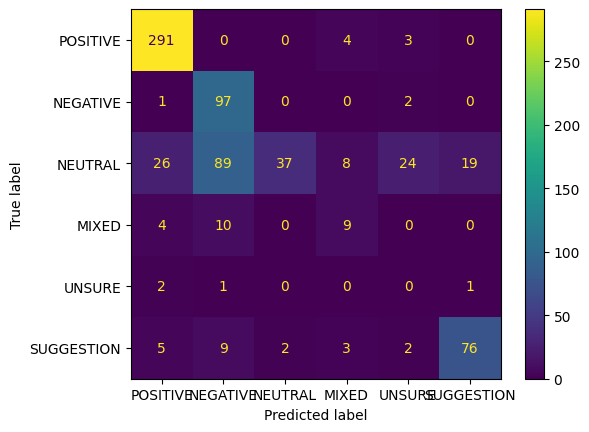

In [46]:
from sklearn.metrics import confusion_matrix,  ConfusionMatrixDisplay, classification_report
cm = confusion_matrix(merged_df['sakthi_annotation'], merged_df['jenny_annotation'], labels=["POSITIVE", "NEGATIVE", "NEUTRAL", "MIXED", "UNSURE","SUGGESTION"])
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["POSITIVE", "NEGATIVE", "NEUTRAL", "MIXED", "UNSURE","SUGGESTION"])
cm_display.plot()

In [47]:
labels=["POSITIVE", "NEGATIVE", "NEUTRAL", "MIXED", "UNSURE","SUGGESTION"]
#Generate classification report
report = classification_report(merged_df['sakthi_annotation'], merged_df['jenny_annotation'], target_names=labels)
print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

    POSITIVE       0.38      0.39      0.38        23
    NEGATIVE       0.47      0.97      0.63       100
     NEUTRAL       0.95      0.18      0.31       203
       MIXED       0.88      0.98      0.93       298
      UNSURE       0.79      0.78      0.79        97
  SUGGESTION       0.00      0.00      0.00         4

    accuracy                           0.70       725
   macro avg       0.58      0.55      0.51       725
weighted avg       0.81      0.70      0.67       725

